# Import Modules

In [1]:
import sys
import os
import pandas as pd
import tqdm as tqdm
import xgboost as xgb
import numpy as np
import optuna

# Import your custom modules. Adjust the module paths as needed.
from src.data.load_data import loadTrainingData
from sklearn.model_selection import train_test_split
from src.features.create_feature_vectors import extract_features_with_expanding_window
from src.plots.feature_plots import plot_roc_auc, plot_confusion_matrix
from sklearn.metrics import classification_report,fbeta_score,confusion_matrix
from sklearn import set_config

set_config(display="text")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', None)


/Users/lukeedwards/anaconda3/envs/ADL/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
directories = ['../../training_setA/', '../../training_setB/']
max_files = None  # Adjust as needed

patient_dict = {}

for directory in directories:
    pattern = os.path.join(directory, "*.psv")
    print(f"\nLoading data from: {pattern} with max_files={max_files}")
    patient_data = loadTrainingData(
        pattern,
        max_files,
        ignore_columns=['Unit2','Unit1','ICULOS','HospAdmTime']
    )
    patient_dict.update(patient_data)


Loading data from: ../../training_setA/*.psv with max_files=None


Loading PSV Files: 100%|██████████| 20336/20336 [00:19<00:00, 1036.83it/s]



Loading data from: ../../training_setB/*.psv with max_files=None


Loading PSV Files: 100%|██████████| 20000/20000 [00:18<00:00, 1077.82it/s]


# Create Feature Vectors

In [3]:
feature_df = extract_features_with_expanding_window(patient_dict)

Extracting features with expanding window: 100%|██████████| 40336/40336 [04:56<00:00, 136.15it/s]
[Parallel(n_jobs=-1)]: Done 40321 out of 40336 | elapsed:  4.9min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 40336 out of 40336 | elapsed:  4.9min finished


Final shape of expanded feature DataFrame: (1552210, 109)


 # Save or Load Feature

In [4]:
def save_feature_data(feature_df, file_path="feature_data.pkl"):
    feature_df.to_pickle(file_path)
    print(f"Feature data saved to {file_path}")

def load_feature_data(file_path="feature_data.pkl"):
    feature_df = pd.read_pickle(file_path)
    print(f"Feature data loaded from {file_path}")
    return feature_df

# feature_df = load_feature_data()
save_feature_data(feature_df)

Feature data saved to feature_data.pkl


# Add/Remove features

In [5]:
feature_df.columns

Index(['HR_5_mean', 'HR_5_min', 'HR_5_max', 'HR_5_median', 'HR_5_var',
       'HR_5_q95', 'HR_5_q05', 'HR_5_energy', 'HR_5_slope', 'O2Sat_5_mean',
       'O2Sat_5_min', 'O2Sat_5_max', 'O2Sat_5_median', 'O2Sat_5_var',
       'O2Sat_5_q95', 'O2Sat_5_q05', 'O2Sat_5_energy', 'O2Sat_5_slope',
       'Temp_5_mean', 'Temp_5_min', 'Temp_5_max', 'Temp_5_median',
       'Temp_5_var', 'Temp_5_q95', 'Temp_5_q05', 'Temp_5_energy',
       'Temp_5_slope', 'SBP_5_mean', 'SBP_5_min', 'SBP_5_max', 'SBP_5_median',
       'SBP_5_var', 'SBP_5_q95', 'SBP_5_q05', 'SBP_5_energy', 'SBP_5_slope',
       'MAP_5_mean', 'MAP_5_min', 'MAP_5_max', 'MAP_5_median', 'MAP_5_var',
       'MAP_5_q95', 'MAP_5_q05', 'MAP_5_energy', 'MAP_5_slope', 'DBP_5_mean',
       'DBP_5_min', 'DBP_5_max', 'DBP_5_median', 'DBP_5_var', 'DBP_5_q95',
       'DBP_5_q05', 'DBP_5_energy', 'DBP_5_slope', 'Resp_5_mean', 'Resp_5_min',
       'Resp_5_max', 'Resp_5_median', 'Resp_5_var', 'Resp_5_q95', 'Resp_5_q05',
       'Resp_5_energy', 'Resp_5_s

In [6]:
feature_df.shape

(1552210, 109)

# Split Sets into Test and Train on Patient ID of Dictionary

In [7]:
# Group rows by patient_id to create a patient-wise dictionary.
patient_groups = {patient_id: group 
                  for patient_id, group in feature_df.groupby("patient_id")}

# Create a new dictionary with keys indicating sepsis status.
# For each patient, if any row's SepsisLabel equals 1, mark that patient as sepsis.
labeled_patients = {}
for patient_id, df in patient_groups.items():
    # Check if the patient ever had sepsis
    sepsis_label = "1" if df["SepsisLabel"].any() else "0"
    new_key = f"{patient_id}_{sepsis_label}"
    labeled_patients[new_key] = df

# Optional: Print counts to verify split counts
sepsis_count = sum(1 for key in labeled_patients if key.endswith('_1'))
nonsepsis_count = sum(1 for key in labeled_patients if key.endswith('_0'))
print(f"Number of SEPSIS patients: {sepsis_count}")
print(f"Number of NON-SEPSIS patients: {nonsepsis_count}")

# Now, create a list of keys and a matching list of binary labels for stratification.
keys = list(labeled_patients.keys())
labels = [1 if key.endswith('_sepsis') else 0 for key in keys]  # 1 = sepsis, 0 = no sepsis

# Split the keys into train and test sets while maintaining the sepsis proportion.
train_keys, test_keys, _, _ = train_test_split(
    keys, labels, test_size=0.2, random_state=42, stratify=labels
)

# Build train and test dictionaries from the split keys.
train_data_dict = {key: labeled_patients[key] for key in train_keys}
test_data_dict = {key: labeled_patients[key] for key in test_keys}

# Optional: Verify the stratification in your splits.
train_sepsis = sum(1 for key in train_data_dict if key.endswith('_1'))
test_sepsis = sum(1 for key in test_data_dict if key.endswith('_1'))
print(f"Train SEPSIS: {train_sepsis}, NON-SEPSIS: {len(train_data_dict) - train_sepsis}")
print(f"Test SEPSIS: {test_sepsis}, NON-SEPSIS: {len(test_data_dict) - test_sepsis}")

# If needed, you can also concatenate these dictionaries back into DataFrames:
train_df = pd.concat(train_data_dict.values(), ignore_index=True)
test_df = pd.concat(test_data_dict.values(), ignore_index=True)

train_df = train_df.drop(columns=['patient_id'])
test_df = test_df.drop(columns=['patient_id'])

Number of SEPSIS patients: 2932
Number of NON-SEPSIS patients: 37404
Train SEPSIS: 2339, NON-SEPSIS: 29929
Test SEPSIS: 593, NON-SEPSIS: 7475


#  Train Model

In [8]:
# Separate features and target
X_train = train_df.drop(columns=["SepsisLabel"], errors="ignore")
y_train = train_df["SepsisLabel"]

X_test = test_df.drop(columns=["SepsisLabel"], errors="ignore")
y_test = test_df["SepsisLabel"]

neg_samples, pos_samples = y_train.value_counts()
neg_samples_test, pos_samples_test = y_test.value_counts()
print(f"Negative samples of Train: {neg_samples}, Positive samples of Train: {pos_samples}")
print(f"Negative samples of Test: {neg_samples_test}, Positive samples of Test: {pos_samples_test}")

Negative samples of Train: 1216103, Positive samples of Train: 22279
Negative samples of Test: 308191, Positive samples of Test: 5637


# Optuna HyperParams

In [ ]:
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import StratifiedKFold, cross_val_score
# from optuna.terminator import report_cross_validation_scores
# from optuna.visualization import plot_terminator_improvement
# from plotly.io import show

# def objective(trial):
#     # Define a search space for hyperparameters.
#     params = {
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1e1),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'objective': 'binary:logistic',
#         'eval_metric': 'auc',
#         'scale_pos_weight': neg_samples / pos_samples,
#         'random_state': 42,
#         'use_label_encoder': False
#     }
    
#     # Use stratified 3-fold cross-validation.
#     skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#     clf = xgb.XGBClassifier(**params)
    
#     # Define a scoring function based on F_beta score with beta=4.5.
#     scorer = make_scorer(fbeta_score, beta=4.5)
#     scores = cross_val_score(clf, X_train, y_train, scoring=scorer, cv=skf)
    
#     # Return the mean F_beta score.
#     return np.mean(scores)

# # Create an Optuna study object to maximize the F_beta score.
# study = optuna.create_study(direction='maximize')
# print("Starting hyperparameter tuning with Optuna...")
# study.optimize(objective, n_trials=15)

# fig = plot_terminator_improvement(study, plot_error=True)
# show(fig)

# # Output the best trial.
# print("Best trial:")
# print("  F_beta Score: ", study.best_trial.value)
# print("  Params: ", study.best_trial.params)

# # Extract best parameters and add fixed parameters.
# best_params = study.best_trial.params
# best_params['objective'] = 'binary:logistic'
# best_params['eval_metric'] = 'auc'
# best_params['scale_pos_weight'] = neg_samples / pos_samples
# best_params['random_state'] = 42
# best_params['use_label_encoder'] = False

[I 2025-03-27 00:19:30,401] A new study created in memory with name: no-name-50158231-7248-4e9d-852c-e678d4eab9d2
/var/folders/t1/dzxwzzsx6zv5_46thgb8kj2c0000gn/T/ipykernel_75820/2094094493.py:10: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/t1/dzxwzzsx6zv5_46thgb8kj2c0000gn/T/ipykernel_75820/2094094493.py:12: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/folders/t1/dzxwzzsx6zv5_46thgb8kj2c0000gn/T/ipykernel_75820/2094094493.py:13: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/folders/t1/dzxwzzsx6zv5_46thgb8kj2c0000gn/T/ipy

Starting hyperparameter tuning with Optuna...


/Users/lukeedwards/anaconda3/envs/ADL/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[00:19:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/lukeedwards/anaconda3/envs/ADL/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[00:19:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/lukeedwards/anaconda3/envs/ADL/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[00:19:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


[I 2025-03-27 00:19:54,029] Trial 0 finished with value: 0.5815012827351661 and parameters: {'learning_rate': 0.08883966411795263, 'max_depth': 6, 'subsample': 0.6408622017334875, 'colsample_bytree': 0.7123838114179107, 'gamma': 0.1505579593741568, 'min_child_weight': 9}. Best is trial 0 with valu

ModuleNotFoundError: No module named 'torch'

In [10]:
# Cell 5: Train model
model = xgb.XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    eval_metric="auc",
    scale_pos_weight=neg_samples / pos_samples
)
model.fit(X_train, y_train, 
          eval_set=[(X_test, y_test)],
          verbose=1)

[0]	validation_0-auc:0.72785
[1]	validation_0-auc:0.75333
[2]	validation_0-auc:0.76034
[3]	validation_0-auc:0.76430
[4]	validation_0-auc:0.77066
[5]	validation_0-auc:0.77701
[6]	validation_0-auc:0.77903
[7]	validation_0-auc:0.78275
[8]	validation_0-auc:0.78484
[9]	validation_0-auc:0.78733
[10]	validation_0-auc:0.78731
[11]	validation_0-auc:0.78907
[12]	validation_0-auc:0.79078
[13]	validation_0-auc:0.79067
[14]	validation_0-auc:0.79122
[15]	validation_0-auc:0.79225
[16]	validation_0-auc:0.79253
[17]	validation_0-auc:0.79260
[18]	validation_0-auc:0.79231
[19]	validation_0-auc:0.79078
[20]	validation_0-auc:0.79037
[21]	validation_0-auc:0.79021
[22]	validation_0-auc:0.79142
[23]	validation_0-auc:0.79020
[24]	validation_0-auc:0.79024
[25]	validation_0-auc:0.79057
[26]	validation_0-auc:0.79013
[27]	validation_0-auc:0.79009
[28]	validation_0-auc:0.79051
[29]	validation_0-auc:0.79033
[30]	validation_0-auc:0.78991
[31]	validation_0-auc:0.78980
[32]	validation_0-auc:0.79016
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

# Evaluate Model

Subset ROC AUC (predicted=1 or actual=1): 0.265


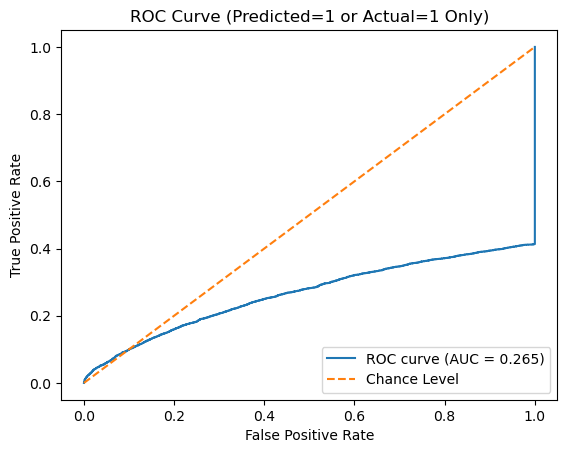

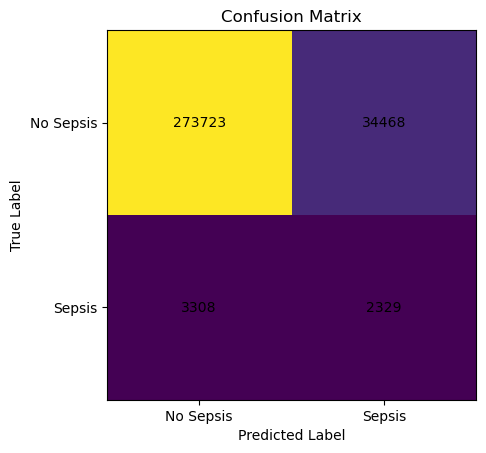


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    308191
         1.0       0.06      0.41      0.11      5637

    accuracy                           0.88    313828
   macro avg       0.53      0.65      0.52    313828
weighted avg       0.97      0.88      0.92    313828



In [11]:
from src.plots.feature_plots import plot_roc_auc, plot_confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

plot_roc_auc(model, X_test, y_test)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=("No Sepsis", "Sepsis"))

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Maximise Threshold

In [17]:
thresholds = np.arange(0.0, 1.0, 0.01)

f_beta_scores = []
beta_val = 4.5

for t in thresholds:
    y_pred_threshold = (y_proba >= t).astype(int)
    fb = fbeta_score(y_test, y_pred_threshold, beta=beta_val)
    f_beta_scores.append(fb)

optimal_threshold = thresholds[np.argmax(f_beta_scores)]
print(f"Optimal threshold: {optimal_threshold}, F Beta {beta_val} Score: {max(f_beta_scores)}")

Optimal threshold: 0.24, F Beta 4.5 Score: 0.39780787491155617


# Re-evaluate Model

Subset ROC AUC (predicted=1 or actual=1): 0.466


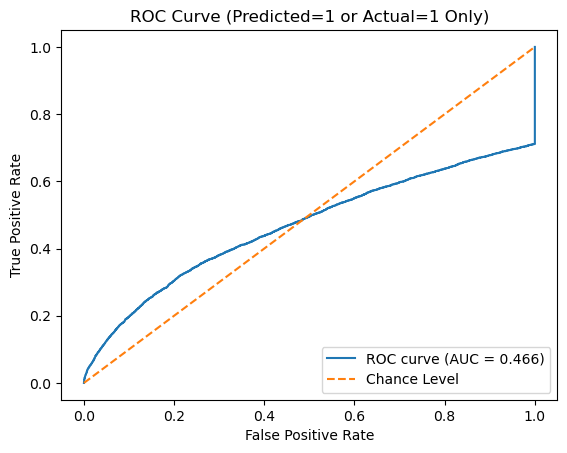

              precision    recall  f1-score   support

         0.0       0.99      0.69      0.81    308191
         1.0       0.04      0.71      0.08      5637

    accuracy                           0.69    313828
   macro avg       0.52      0.70      0.44    313828
weighted avg       0.98      0.69      0.80    313828

[[211883  96308]
 [  1622   4015]]


In [18]:
# Get predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Apply the threshold to get the new predictions
y_pred_custom = (y_proba >= optimal_threshold).astype(int)


plot_roc_auc(model, X_test, y_test, optimal_threshold)

print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))

# Feature Importance

In [14]:
feature_importances = model.feature_importances_
features = X_test.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
importance_df.head(100)

,Feature,Importance
73,FiO2,0.046813
99,shock_index,0.040357
20,Temp_5_max,0.033807
65,Temp,0.023160
85,Lactate,0.021196
31,SBP_5_var,0.019029
106,partial_sofa,0.017186
78,BUN,0.016440
60,Resp_5_q05,0.015581
82,Creatinine,0.015401


# Shap Importance

# Utility Score

# Most Important Features